# TORCHVISION 객체 검출 미세조정(FINETUNING) 튜토리얼

- [Penn-Fudan Database for Pedestrian Detection and Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/)
    - Pedestrian Instance Segmetation 데이터셋
    - 총 170개의 이미지, 345명의 사람 데이터
- [Mask R-CNN](https://arxiv.org/abs/1703.06870) 모델 fine tuning
- [튜토리얼 참고 Colab](https://colab.research.google.com/github/pytorch/vision/blob/temp-tutorial/tutorials/torchvision_finetuning_instance_segmentation.ipynb)

## 1. 데이터셋 정의하기

- 사용자 정의 데이터셋 정의
    - 표준 `torch.utils.data.Dataset` 클래스 상속
    - `__len__`, `__getitem__` 메소드 구현
    - `__getitem__`은 return을 해야함
- 이미지
    - `(H, W)`의 PIL
- Target이 포함해야 하는 정보
  - `boxes (FloatTensor[N, 4])`
      - `N` 개 바운딩 박스(Bounding box)들의 좌표(`[x0, y0, x1, y1]`)
      - x값 범위 : `0` \~ `W`
      - y값 범위 : `0` \~ `H`
  - `labels (Int64Tensor[N])`
      - 각 바운딩 박스에 대한 label 정보
      - `0` 은 background
      
  - `image_id (Int64Tensor[1])`
      - 데이터셋의 각 이미지에 대한 고유한 값(id)
  - `area (Tensor[N])`
      - Bounding box의 면적
      - Test시, 작음, 중간, 큰 박스 간의 점수를 내기 위한 기준이며 COCO를 기준으로 함
  - `iscrowd (UInt8Tensor[N])`
      - 이 값이 참일 경우 test에서 제외 (너무 사람이 많은 경우라서 그런듯??)
  - (선택) `masks (UInt8Tensor[N, H, W])`
      - `N` 개 객체마다의 segmentation mask 정보
  - (선택) `keypoints (FloatTensor[N, K, 3])`
      - `N` 개 객체마다의 keypoint 정보
      - Keypoint는 `[x, y, visibility]` 형태의 값
          - `visibility`가 0인 경우, 키포인트는 보이지 않음을 의미
          - Data augmentation의 경우, 키포인트 좌우 반전은 데이터 표현에 따라 달라지며, 새로운 키포인트 표현에 대해 “references/detection/transforms.py” 코드 부분을 수정 해야 할 수도 있음

위의 방법대로 리턴을 하면, train, test에 대해 정상적으로 동작하고, test script는 `pycocotools` 를 사용할 수 있음

#### 참고
- 만약, 데이터셋에 background가 없이 다른 class들만으로 구성된다하더라도 0은 사용하지 않아야 함.
    - Ex) 개와 고양이를 분류할 경우, 개에 1 고양이에 2를 할당 (개에 0, 고양이에 1 이런식으로 하면 안됨)
- 추가로, 학습 중에 가로 세로 비율 그룹화를 사용하려는 경우(각 배치에 유사한 가로 세로 비율이 있는 영상만 포함되도록), 이미지의 넓이, 높이를 리턴할 수 있도록 get_height_and_width 메소드를 구현하기를 추천
    - 이 메소드가 구현되지 않은 경우에는 모든 데이터셋은 `__getitem__` 를 통해 메모리에 이미지가 로드되며 사용자 정의 메소드를 제공하는 것보다 느릴 수 있음

####  PennFudan 데이터셋 내려받기

아래 명령어를 통해 데이터셋을 내려받고, unzip

> $ wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

다음과 같은 디렉토리 구조가 있는 것을 확인

```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

In [1]:
import os
import numpy as np
import torch
from PIL import Image

class PennFudanDataset():
    
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)
        
        # 각 instance들이 다른 색들로 encoding 되어있음
        obj_ids = np.unique(mask)
         # background 제거
        obj_ids = obj_ids[1:]
        
        # color encoding된 마스크를 각 class별 binary mask로 변환하는 코드
        # : obj_ids[:, None, None]는 obj_ids.reshape(-1, 1, 1)와 동일
        #   즉, np.array([[[1]], [[2]]])와 동일하고, shape는 (2, 1, 1)
        masks = mask == obj_ids[:, None, None]
        
        # 각 mask의 bounding box 좌표 가져오기
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i]) # ([y 좌표들], [x 좌표들])의 형태로 tuple을 반환
            x_min = np.min(pos[1])
            x_max = np.max(pos[1])
            y_min = np.min(pos[0])
            y_max = np.max(pos[0])
            boxes.append([x_min, y_min, x_max, y_max])
        
        # torch.Tensor로 type casting
        boxes = torch.tensor(boxes, dtype=torch.float32)
        # object는 사람밖에 없어서 그냥 ones로 객체 수(사람 수)만큼 만듦
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # 1, 0으로 이루어진 torch.Tensor(dtype=uint8)로 type casting
        # from_numpy()랑 동일 (메모리 공유)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        image_id = torch.tensor([idx])
        
        # area = y_max-y_min * x_max-x_min
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # 모든 instance는 crowd(군중) 상태가 아니라고 가정
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

## 2. 모델 정의하기

- Torchvision model zoo에서 모델을 사용하는 2가지 상황에 대해 실습
    1. Pre-trained 모델의 마지막 layer만 fine-tuning
    2. 모델의 backbone을 다른 backbone으로 교체
        - Ex) 더 빠른 예측을 하려고 할때, backbone을 ResNet101 에서 MobilenetV2 로 교체

### 2-1. Pre-trained 모델의 마지막 layer만 fine-tuning

In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# COCO에서 학습된 모델
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# 분류할 class 수
num_classes = 2
# 분류기에 들어올 input feature의 차원
in_features = model.roi_heads.box_predictor.cls_score.in_features
# pretrained model의 box predictor를 교체
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### 2-2. 모델의 backbone을 다른 backbone으로 교체

In [3]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# pretrained-weight는 ~/.cache/torch/hub/checkpoints에 저장됨
backbone = torchvision.models.mobilenet_v2(pretrained=True).features

# backbone의 output feature의 channel
backbone.out_channels = 1280

# RPN(Region Proposal Network)가 서로 다른 크기의 5개 anchor box와 aspect ratio를 가지도록 설정
# 즉, 5 x 3개의 anchor를 각 공간 위치마다 생성하도록 함
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512)),
                                   aspect_ratios=((0.5, 1.0, 2.0)))

# Region of Interest(ROI)의 자르기 및 재할당 후 자르기 크기를 수행하는 데 사용할 피쳐 맵을 정의
# backbone이 텐서를 리턴할때, featmap_names는 [0]으로 설정
# 자세한 내용은 API문서 참고(https://pytorch.org/vision/stable/ops.html)
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# Faster RCNN 모델 생성
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

## 3. PennFudan 데이터셋을 위한 인스턴스 분할 모델

- Dataset의 크기가 매우 작으므로, \[2-1. Pre-trained 모델의 마지막 layer만 fine-tuning\] 방법을 사용
- Detection과 더불어서 instance segmentation까지 수행하므로, 아래의 2개 클래스를 사용
    - `FastRCNNPredictor`
    - `MaskRCNNPredictor`

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # COCO에서 학습된 인스턴스 분할 모델
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # class 분류를 위한 input feature의 차원
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # pretrained model의 box predictor를 교체
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # 마스크 분류를 위한 input feature의 차원
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # pretrained model의 mask predictor를 교체
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

## 4. 학습 및 검증

- https://github.com/pytorch/vision/tree/master/references 에서 다음의 모듈들을 사용
    - *transforms.py*, *engine.py*, *utils.py*, *coco_utils.py*, *coco_eval.py*를 사용
- Data augmentation과 transform을 위한 helper function `get_transform()` 정의
- Train, validation을 수행

In [5]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        # (역자주: 학습시 50% 확률로 학습 영상을 좌우 반전 변환합니다)
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [6]:
from engine import train_one_epoch, evaluate
import utils

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
root = "./data/PennFudanPed"
dataset = PennFudanDataset(root, get_transform(train=True))
dataset_val = PennFudanDataset(root, get_transform(train=False))

# train, val split : 50개를 validation, 나머지를 train에 사용
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

model = get_model_instance_segmentation(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

num_epochs = 10

for epoch in range(num_epochs):
    # 10 epoch동안 학습하고, 10 iter마다 출력
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    # val set에서 평가
    evaluate(model, data_loader_val, device=device)

print("That's it!")

/home/youngsuk/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/60]  eta: 0:01:06  lr: 0.000090  loss: 3.8958 (3.8958)  loss_classifier: 0.7050 (0.7050)  loss_box_reg: 0.1811 (0.1811)  loss_mask: 2.9842 (2.9842)  loss_objectness: 0.0243 (0.0243)  loss_rpn_box_reg: 0.0012 (0.0012)  time: 1.1042  data: 0.1187  max mem: 1856
Epoch: [0]  [10/60]  eta: 0:00:50  lr: 0.000936  loss: 1.7390 (2.4017)  loss_classifier: 0.4429 (0.4680)  loss_box_reg: 0.2759 (0.2803)  loss_mask: 1.0425 (1.6263)  loss_objectness: 0.0230 (0.0232)  loss_rpn_box_reg: 0.0025 (0.0038)  time: 1.0092  data: 0.0137  max mem: 3165
Epoch: [0]  [20/60]  eta: 0:00:40  lr: 0.001783  loss: 1.0514 (1.5778)  loss_classifier: 0.2168 (0.3148)  loss_box_reg: 0.2676 (0.2554)  loss_mask: 0.4662 (0.9798)  loss_objectness: 0.0215 (0.0235)  loss_rpn_box_reg: 0.0035 (0.0043)  time: 1.0187  data: 0.0036  max mem: 3475
Epoch: [0]  [30/60]  eta: 0:00:30  lr: 0.002629  loss: 0.6253 (1.2497)  loss_classifier: 0.0963 (0.2388)  loss_box_reg: 0.1996 (0.2460)  loss_mask: 0.2387 (0.7389)  loss_ob

Epoch: [2]  [ 0/60]  eta: 0:01:05  lr: 0.005000  loss: 0.2416 (0.2416)  loss_classifier: 0.0229 (0.0229)  loss_box_reg: 0.0328 (0.0328)  loss_mask: 0.1843 (0.1843)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0012 (0.0012)  time: 1.0851  data: 0.1131  max mem: 3597
Epoch: [2]  [10/60]  eta: 0:00:48  lr: 0.005000  loss: 0.2416 (0.2505)  loss_classifier: 0.0229 (0.0249)  loss_box_reg: 0.0705 (0.0672)  loss_mask: 0.1425 (0.1535)  loss_objectness: 0.0006 (0.0016)  loss_rpn_box_reg: 0.0027 (0.0034)  time: 0.9748  data: 0.0136  max mem: 3597
Epoch: [2]  [20/60]  eta: 0:00:40  lr: 0.005000  loss: 0.2433 (0.2450)  loss_classifier: 0.0262 (0.0282)  loss_box_reg: 0.0634 (0.0636)  loss_mask: 0.1425 (0.1471)  loss_objectness: 0.0006 (0.0017)  loss_rpn_box_reg: 0.0029 (0.0045)  time: 1.0089  data: 0.0040  max mem: 3597
Epoch: [2]  [30/60]  eta: 0:00:30  lr: 0.005000  loss: 0.2348 (0.2386)  loss_classifier: 0.0288 (0.0293)  loss_box_reg: 0.0590 (0.0615)  loss_mask: 0.1264 (0.1416)  loss_ob

Epoch: [4]  [ 0/60]  eta: 0:01:08  lr: 0.000500  loss: 0.1271 (0.1271)  loss_classifier: 0.0089 (0.0089)  loss_box_reg: 0.0159 (0.0159)  loss_mask: 0.0987 (0.0987)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0027 (0.0027)  time: 1.1407  data: 0.1104  max mem: 3597
Epoch: [4]  [10/60]  eta: 0:00:51  lr: 0.000500  loss: 0.1471 (0.1480)  loss_classifier: 0.0167 (0.0186)  loss_box_reg: 0.0206 (0.0240)  loss_mask: 0.0987 (0.1026)  loss_objectness: 0.0007 (0.0008)  loss_rpn_box_reg: 0.0016 (0.0020)  time: 1.0325  data: 0.0136  max mem: 3597
Epoch: [4]  [20/60]  eta: 0:00:40  lr: 0.000500  loss: 0.1641 (0.1779)  loss_classifier: 0.0231 (0.0239)  loss_box_reg: 0.0301 (0.0343)  loss_mask: 0.1062 (0.1158)  loss_objectness: 0.0007 (0.0009)  loss_rpn_box_reg: 0.0030 (0.0030)  time: 1.0167  data: 0.0042  max mem: 3597
Epoch: [4]  [30/60]  eta: 0:00:31  lr: 0.000500  loss: 0.1897 (0.1850)  loss_classifier: 0.0268 (0.0262)  loss_box_reg: 0.0412 (0.0372)  loss_mask: 0.1246 (0.1176)  loss_ob

Epoch: [6]  [ 0/60]  eta: 0:01:03  lr: 0.000050  loss: 0.1286 (0.1286)  loss_classifier: 0.0075 (0.0075)  loss_box_reg: 0.0174 (0.0174)  loss_mask: 0.1022 (0.1022)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0012 (0.0012)  time: 1.0642  data: 0.1418  max mem: 3597
Epoch: [6]  [10/60]  eta: 0:00:50  lr: 0.000050  loss: 0.1498 (0.1702)  loss_classifier: 0.0185 (0.0225)  loss_box_reg: 0.0257 (0.0336)  loss_mask: 0.1117 (0.1108)  loss_objectness: 0.0004 (0.0007)  loss_rpn_box_reg: 0.0024 (0.0026)  time: 1.0121  data: 0.0158  max mem: 3597
Epoch: [6]  [20/60]  eta: 0:00:40  lr: 0.000050  loss: 0.1673 (0.1773)  loss_classifier: 0.0199 (0.0233)  loss_box_reg: 0.0304 (0.0369)  loss_mask: 0.1083 (0.1137)  loss_objectness: 0.0004 (0.0006)  loss_rpn_box_reg: 0.0024 (0.0028)  time: 1.0196  data: 0.0038  max mem: 3597
Epoch: [6]  [30/60]  eta: 0:00:29  lr: 0.000050  loss: 0.1614 (0.1716)  loss_classifier: 0.0194 (0.0224)  loss_box_reg: 0.0252 (0.0335)  loss_mask: 0.1039 (0.1122)  loss_ob

Epoch: [8]  [ 0/60]  eta: 0:01:02  lr: 0.000050  loss: 0.1467 (0.1467)  loss_classifier: 0.0219 (0.0219)  loss_box_reg: 0.0211 (0.0211)  loss_mask: 0.1029 (0.1029)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 1.0408  data: 0.1527  max mem: 3597
Epoch: [8]  [10/60]  eta: 0:00:49  lr: 0.000050  loss: 0.1663 (0.1637)  loss_classifier: 0.0244 (0.0239)  loss_box_reg: 0.0330 (0.0294)  loss_mask: 0.1047 (0.1074)  loss_objectness: 0.0005 (0.0009)  loss_rpn_box_reg: 0.0016 (0.0020)  time: 0.9815  data: 0.0174  max mem: 3597
Epoch: [8]  [20/60]  eta: 0:00:40  lr: 0.000050  loss: 0.1663 (0.1706)  loss_classifier: 0.0244 (0.0240)  loss_box_reg: 0.0330 (0.0330)  loss_mask: 0.1037 (0.1109)  loss_objectness: 0.0003 (0.0007)  loss_rpn_box_reg: 0.0016 (0.0020)  time: 1.0025  data: 0.0041  max mem: 3597
Epoch: [8]  [30/60]  eta: 0:00:30  lr: 0.000050  loss: 0.1649 (0.1683)  loss_classifier: 0.0204 (0.0222)  loss_box_reg: 0.0312 (0.0320)  loss_mask: 0.1037 (0.1109)  loss_ob

## 5. 결과 확인

In [7]:
img, _ = dataset_val[0]

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
    
print(prediction)

[{'boxes': tensor([[ 92.7168,  40.1758, 194.4350, 288.8184],
        [ 61.6492,  22.0829, 111.8305, 226.1477]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.9926], device='cuda:0'), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}]


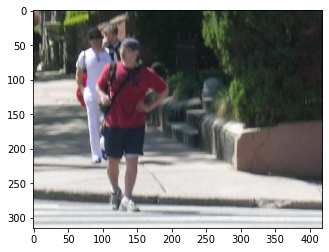

In [8]:
import matplotlib.pyplot as plt

plt.imshow(Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy()))
plt.show()

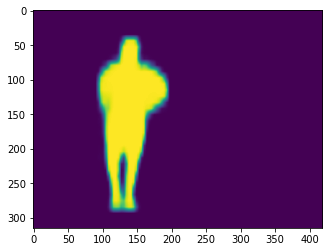

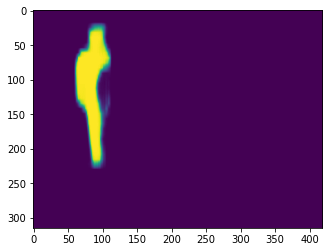

In [9]:
for i in range(len(prediction[0]['masks'])):
    plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
    plt.show()